# Imports

In [1]:
# Move to the root
import os
cwd = os.getcwd()
if os.path.basename(cwd) != "cv-in-farming":
    os.chdir("../")
print(os.getcwd())

/home/cengerkin/Desktop/cv-in-farming


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import pyrealsense2 as rs # Intel RealSense cross-platform open-source API
import open3d as o3d

from utils.helpers import *
from src.image_processing import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Read rosbag, Sample a Frame with Respective Intrinsics 

In [3]:
# Read rosbag file
ros_file = "./videos/back_left(20201112_133434).bag"
pipe = rs.pipeline()
cfg = rs.config()
cfg.enable_device_from_file(ros_file)
profile = pipe.start(cfg)

In [4]:
# Extract a set of frames 
frameset = pipe.wait_for_frames()
color_frame = frameset.get_color_frame()
depth_frame = frameset.get_depth_frame()
frame_number = frameset.get_frame_number()
frame_stamp = frameset.get_timestamp()
colorizer = rs.colorizer()
print(f"Frame Number: {frame_number}")
print(f"Frame Timestamp: {frame_stamp}")

Frame Number: 12786
Frame Timestamp: 1605184475224.7678


In [5]:
# Align depth array to RGB
align = rs.align(rs.stream.color)
frameset = align.process(frameset)
aligned_depth_frame = frameset.get_depth_frame()

In [6]:
# RGB image
color = np.asanyarray(color_frame.get_data())
rgb_image = Image.fromarray(color)

# Aligned depth image
colorized_depth = np.asanyarray(colorizer.colorize(aligned_depth_frame).get_data())
depth_image = Image.fromarray(colorized_depth)

# Aligned depth array
depth_scale = profile.get_device().first_depth_sensor().get_depth_scale()
depth_arr = np.asanyarray(aligned_depth_frame.get_data()) # in meters
depth_arr = depth_arr * depth_scale

# Retrieve intrinsics matrix
intrinsics = color_frame.profile.as_video_stream_profile().get_intrinsics()

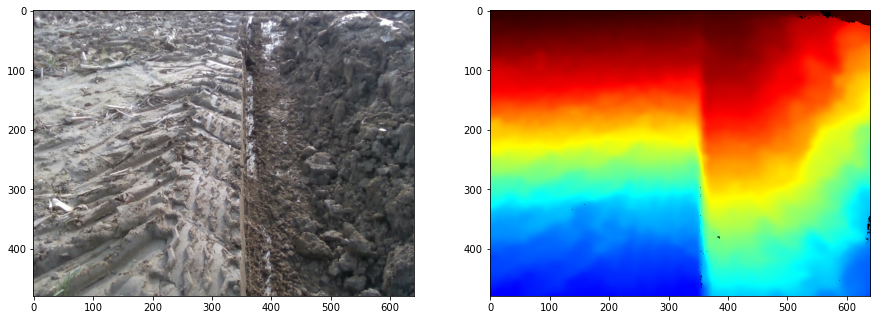

In [7]:
show_image_pairs(rgb_image, depth_image)

# Detect Features (Corners & Edge)

[Info]: Applying template matching with args:
- start_depth: 1.0
- contour_width: 25
- y_step: 25
- n_contours: 200
- dynamic_width: True
- ransac_thresh: 15
- score_thresh: None
- roi: [None, None, 250, None]
- fit_type: curve
- verbose: 1

[Info]: Template shape: (30, 30)


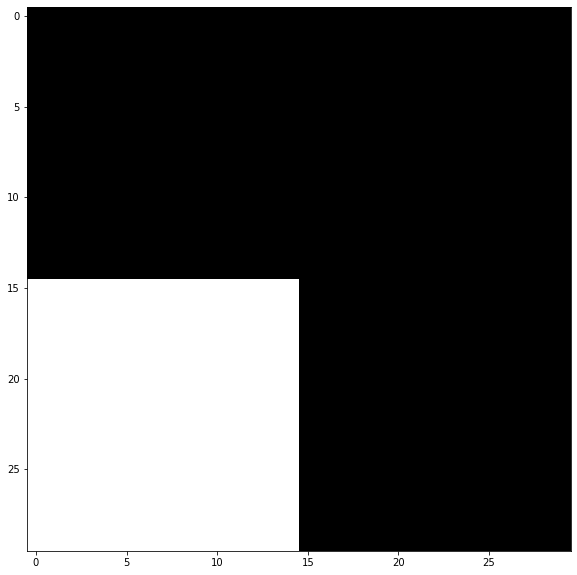

[Warning]: Contour-11: (3.88-5.26) is out-of-bounds(5.05). Stopping with 11 contours.
[Info]: Inliers/All: 10/11, Ratio: 0.91


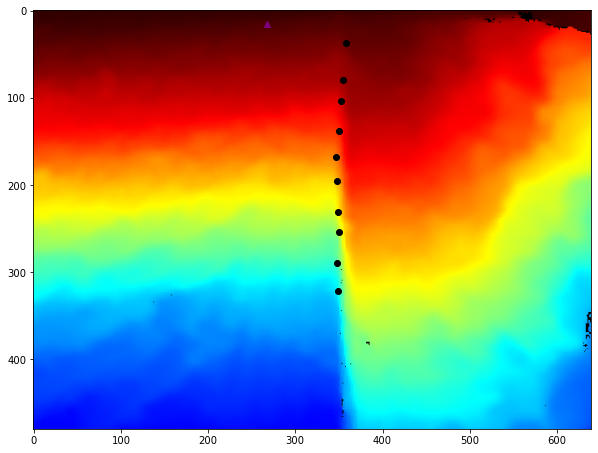

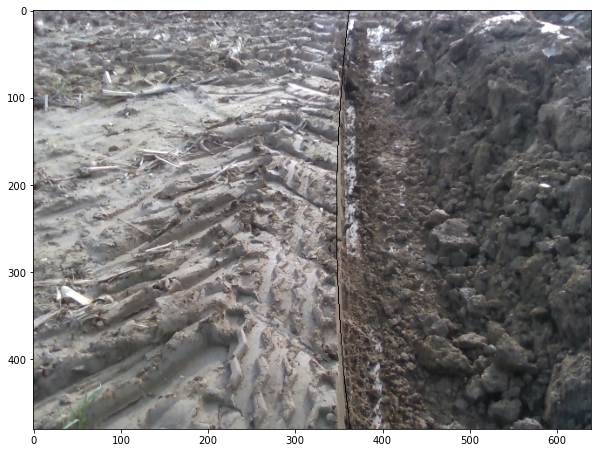

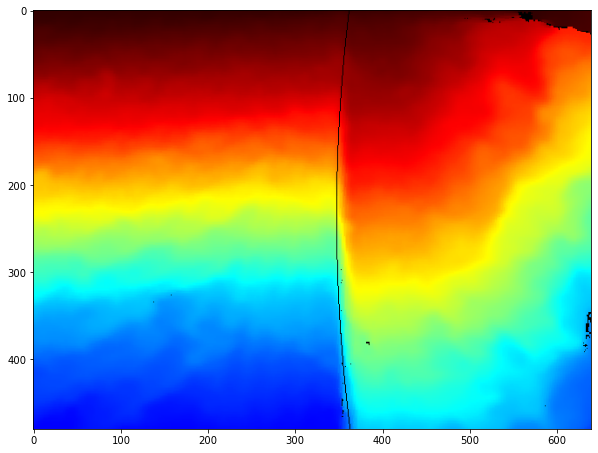

In [8]:
template = create_template(size=30, position=3) 
pixels, corners, outliers = apply_template_matching(depth_arr.astype(np.float32), 
                                                    template,
                                                    y_step=25,
                                                    n_contours=200,
                                                    fit_type="curve",
                                                    verbose=1)

plt.figure(figsize=(10,10))
plt.imshow(depth_image)
plt.scatter(corners[:,1], corners[:,0], color="black", marker="o")
plt.scatter(outliers[:,1], outliers[:,0], color="purple", marker="^")
plt.show()

mask = coord_to_mask(depth_arr.shape, pixels)
    
show_overlay(np.array(rgb_image), mask)
show_overlay(np.array(depth_image), mask)

# Shift Detection, Visualize in 3D

In [9]:
pc = rs.pointcloud()
points = pc.calculate(aligned_depth_frame)

# Get camera coordinates per pixel with shape: (H,W,3)
cam_coords3D = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(480, 640, 3))

# Flatten camera coordinates with shape (H,W,3) to array with shape (H*W,3)
flat_cam_coords3D = cam_coords3D.reshape(-1, 3)

# Take a copy of pixel coordinate of corners shifted with shift3D vector
shifted2D = shift_pixels(depth_arr, pixels, intrinsics, shift3D=(+0.25,0,0))

# Generate lanes
lane_coords = generate_lane_pixels(shifted2D, pixels)

## Define colors for each 3D point
colors = colorized_depth.copy()
colors[pixels[:,0], pixels[:,1]] = 0 # Denote original corners with black
colors[shifted2D[:,0], shifted2D[:,1]] = 0 # Denote shifted corners with black
colors[lane_coords[:,0], lane_coords[:,1]] = 0 # Denote lane points with black
colors = colors.reshape(-1, 3).astype(np.float64) # Flatten and adjust type
colors = colors / colors.max() # Open3D expects intensity values as float in [0,1]

# Convert point cloud into Open3D format
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(flat_cam_coords3D)
pcd.colors = o3d.utility.Vector3dVector(colors)

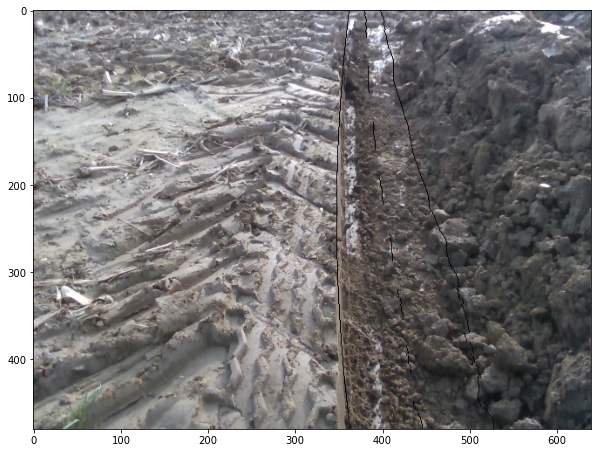

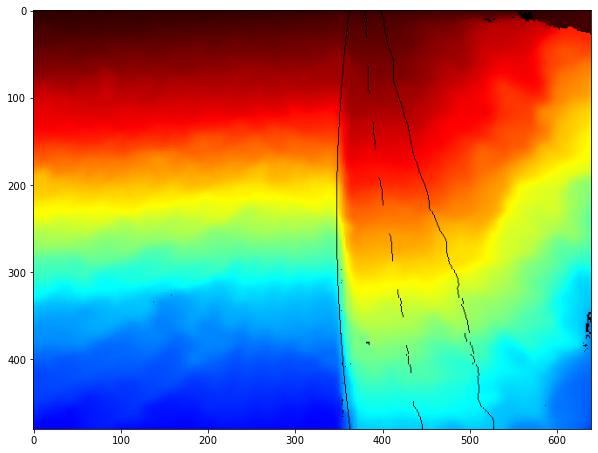

In [10]:
# Visualize in both 2D and 3D
shifted_mask = coord_to_mask(depth_arr.shape, shifted2D)
lane_mask = coord_to_mask(depth_arr.shape, lane_coords)
overall_mask = shifted_mask | lane_mask | mask

show_overlay(np.array(rgb_image), overall_mask)
show_overlay(np.array(depth_image), overall_mask)

o3d.visualization.draw_geometries([pcd], zoom=0.02,
                                  front=[0, 0, -1],
                                  lookat=[0, 0, 1],
                                  up=[0, -1, 0])

# Notes from RealSense:

* Pixel coordinate `[0,0]` refers to the center of the top left pixel in the image, and `[w-1,h-1]` referring to the center of the bottom right pixel in an image containing exactly w columns and h rows. That is, from the perspective of the camera, the x-axis points to the right and the y-axis points down.
* 3D coordinate space, specified in meters, with the coordinate `[0,0,0]` referring to the center of the physical imager.
* Within this space, the positive x-axis points to the right, the positive y-axis points down, and the positive z-axis points forward.
* `rs2_deproject_pixel_to_point(...)` function requires knowledge of the depth of that pixel in meters.
* Depth is stored as one unsigned 16-bit integer per pixel, mapped linearly to depth in camera-specific units. The distance, in meters, corresponding to one integer increment in depth values can be queried via `rs2_get_depth_scale(...)` or using a `rs2::depth_sensor via get_depth_scale()`.
* If a device fails to determine the depth of a given image pixel, a value of zero will be stored in the depth image. This is a reasonable sentinel for "no depth" because all pixels with a depth of zero would correspond to the same physical location, the location of the imager itself.
* The default scale of a D400 device is one millimeter (0.001 m), allowing for a maximum expressive range of ~65 meters. (0.001 indicates millimeter scale, while 0.01 indicates centimeter scale.)
* Stereo disparity is related to depth via an inverse linear relationship (disparity linearly decreases as the value of the depth increases.).

# Aside

In [ ]:
# points = pc.calculate(aligned_depth_frame)
# cam_coords3D = np.ndarray(buffer=points.get_vertices(), dtype=np.float32, shape=(480, 640, 3))
x = np.arange(640)
y = np.arange(480)
x, y = np.meshgrid(x, y)
coords = np.c_[y.ravel(), x.ravel()]
P = backproject(depth_arr, coords, intrinsics)
coords2 = project(P, intrinsics)

In [ ]:
def pick_points(pcd):
    vis = o3d.visualization.VisualizerWithVertexSelection()
    vis.create_window()
    vis.add_geometry(pcd)
    vctl = vis.get_view_control()
    vctl.set_front([0, 0, -1])
    vctl.set_lookat([0, 0, 1])
    vctl.set_up([0, -1, 0])
    vctl.set_zoom(0.02)
    vis.run()
    vis.destroy_window()
    return vis.get_picked_points()

In [ ]:
pts = pick_points(pcd)

In [ ]:
pixel_distance_in_meters = aligned_depth_frame.get_distance(loc[1], loc[0])
print("Distance in meters:", pixel_distance_in_meters)
print("Depth scale in meters:", depth_scale)
print("Raw reading:", depth_arr[loc]/depth_scale)
print("Scaled reading:", depth_arr[loc])
print(np.isclose(pixel_distance_in_meters, depth_arr[loc]))
# help(aligned_depth_frame.get_distance)
# help(aligned_depth_frame.get_units)